# IDS Bayesian Interferometry

In [1]:
import pymc3 as pm
import numpy as np

WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.


In [2]:
def show_fft_image(img_fft, shift = True, save = False , name = 'my_name.png'):
    
    img_fftabs = img_fft
    if type(img_fft[0,0]) == np.complex128:
        img_fftabs = np.abs(img_fft)
    
    if shift:
        img_fftabs = np.fft.fftshift(img_fftabs)
    plt.imshow(img_fftabs)
    
    if save:
        plt.savefig(name, format= 'png')
    
    plt.show()

## Creating artificial data

In [3]:
size = 1
MAX_VALUE = 255
MIN_VALUE = 0
IMAGE_SIZE_X = 20
IMAGE_SIZE_Y = 20
SIGMA = 4

#I = np.ceil((MAX_VALUE - MIN_VALUE) * np.random.rand(size) + MIN_VALUE)
#Cx = np.ceil((IMAGE_SIZE_X)/2 + SIGMA*np.random.randn(size)).astype('int')
#Cx = np.clip(Cx,0,IMAGE_SIZE_X)
#Cy = np.ceil((IMAGE_SIZE_Y)/2 +  SIGMA*np.random.randn(size)).astype('int')
#Cy = np.clip(Cy,0,IMAGE_SIZE_Y)

I = np.array([180])
Cx = np.array([10])
Cy = np.array([5])

minI = np.min(I)
argminI = np.argmin(I)
maxI = np.max(I)
argmaxI = np.argmax(I)

print('min I: %s at (%s,%s)\n' \
      'max I: %s at (%s,%s)\n' % (minI, Cx[argminI], Cy[argminI],
                                  maxI, Cx[argmaxI], Cy[argmaxI]))

min I: 180 at (10,5)
max I: 180 at (10,5)



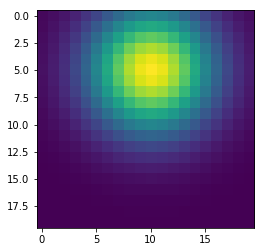

In [4]:
import matplotlib.pyplot as plt
from modelfunctions import *

Im_sinthc = sintheticImage(I,Cx,Cy, l=SIGMA, IMAGE_SIZE_X = IMAGE_SIZE_X, IMAGE_SIZE_Y = IMAGE_SIZE_Y)
plt.imshow(Im_sinthc)
plt.savefig('img_sinthc.png', format='png')
plt.show()

img = Im_sinthc #rename variable

In [5]:
# Calculate the spectrum
img_fft, img_fftabs = spectrum(img)

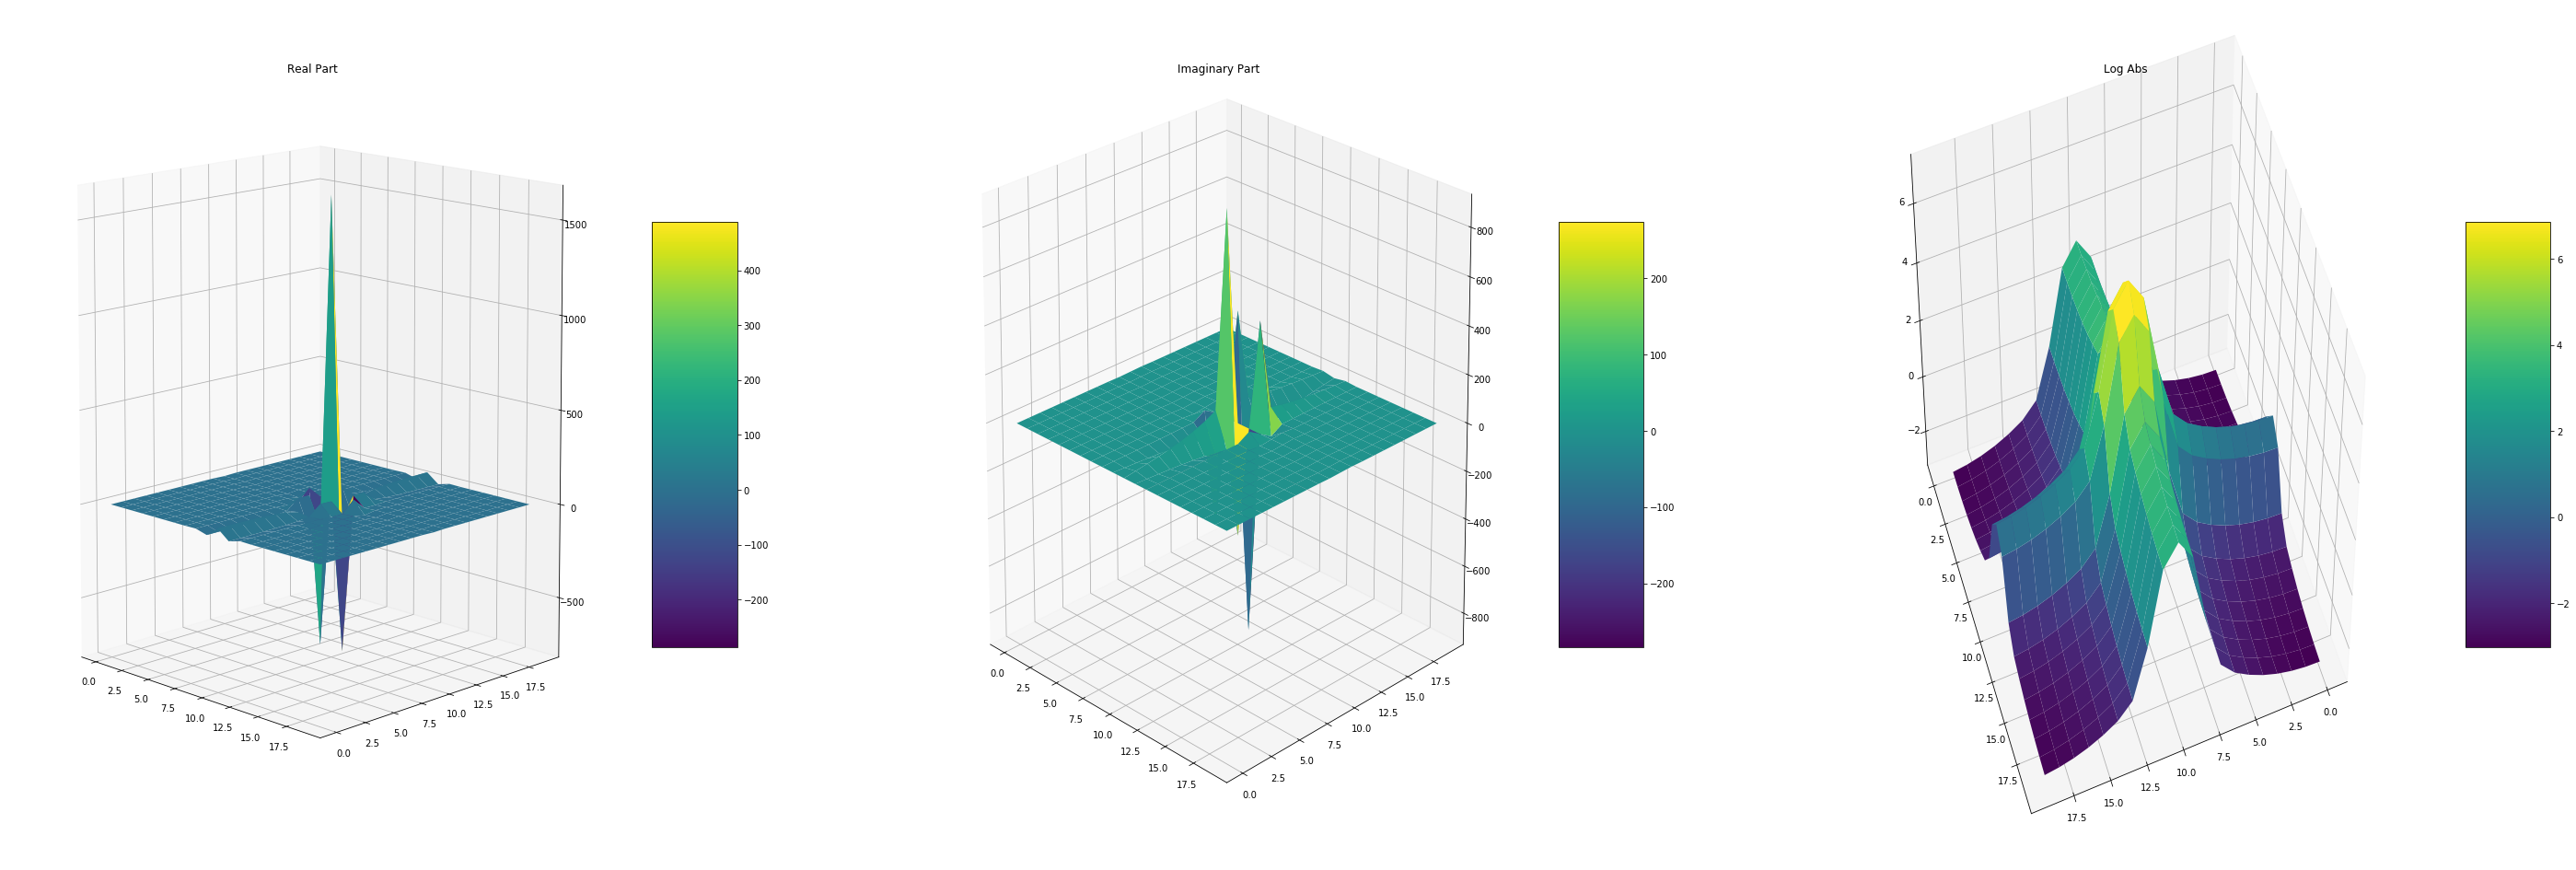

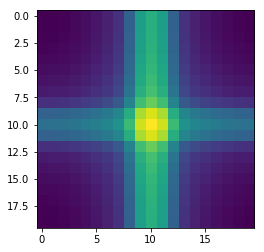

In [6]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

# 3D plotting
fig = plt.figure(figsize=plt.figaspect(0.5))
ax = fig.add_subplot(1, 3, 1, projection='3d')


UU = np.arange(0,IMAGE_SIZE_X,1)
VV = np.arange(0,IMAGE_SIZE_Y,1)
UU, VV = np.meshgrid(UU, VV)
WW = np.fft.fftshift(img_fft.real)


## Plot the surface.
surf = ax.plot_surface(UU, VV, WW, cmap=cm.viridis)
# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)
ax.set_title("Real Part")

ax.view_init(elev=10., azim = -45)

# 3D plotting
ax = fig.add_subplot(1, 3, 2, projection='3d')


UU = np.arange(0,IMAGE_SIZE_X,1)
VV = np.arange(0,IMAGE_SIZE_Y,1)
UU, VV = np.meshgrid(UU, VV)
WW = np.fft.fftshift(img_fft.imag)


## Plot the surface.
surf = ax.plot_surface(UU, VV, WW, cmap=cm.viridis)
# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)
ax.set_title("Imaginary Part")

ax.view_init(elev=20., azim = -45)

# 3D plotting
ax = fig.add_subplot(1, 3, 3, projection='3d')

UU = np.arange(0,IMAGE_SIZE_X,1)
VV = np.arange(0,IMAGE_SIZE_Y,1)
UU, VV = np.meshgrid(UU, VV)
WW = np.fft.fftshift(np.log(img_fftabs+0.001))


## Plot the surface.
surf = ax.plot_surface(UU, VV, WW, cmap=cm.viridis)
# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)
ax.set_title("Log Abs")

ax.view_init(elev=50., azim = 70)

fig.set_figheight(17)
fig.set_figwidth(50)

plt.savefig('img_sinthc_fourier.pdf', format='pdf')
plt.show(fig)

show_fft_image(np.log(img_fftabs+1e-12), save=True, name = 'Im_fft.png')

## Creating sampling mask


For creating the sampling mask, we have made a u,v representations based on the antennas disposition. This is because, if the antennas disposition is random, the measures are not completely random. The Measurements positions are defined by the interferometry physics.

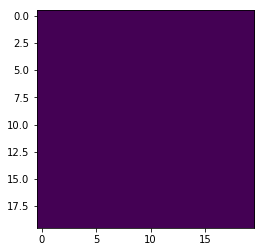

In [7]:
from masking import *

## Parameters
B_max = 1
antennas = 60
typeArray = 'ALL'
sigma = B_max/6.0

lambda_phy=3*10**(-6); #(km)
H0=10; #(deg)
delta0=-30; #(deg)
Lat=34.05;  #(deg) Lat VLA

## Masking function returns the mask
mask = createSpectrumMasking(B_max,antennas,typeArray,sigma, lambda_phy, H0, delta0, Lat, N1 = IMAGE_SIZE_X, N2 = IMAGE_SIZE_Y)
show_fft_image(mask)

## Sampling

Variable `measurements` are the 2D representation for the measurements. `U` are the positions in the `u,v` spaces, i.e., `U[0] = u`, `U[1] = v`. Finally, `V` is the visibility function.

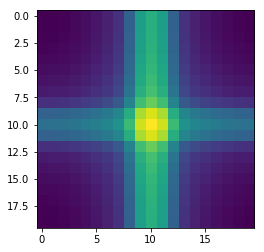

In [8]:
measurements,U,V = UVCreator(np.fft.fftshift(img_fft),mask)

measurements_abs = np.log(np.abs(measurements)+1e-12)
show_fft_image(measurements_abs, shift=False)

## RBF Model
### Priors and Model

$$
V_{obs}(u,v) = \sum_{i=0}^{N_{b}-1}\alpha_i\phi_i(u,v)
$$

donde $\alpha_i \in \mathbb{R}$ y:

$$\phi_i(u,v) = \left[\begin{array}{c}
    \exp\big\lbrace\frac{-2\pi^2(u^2+v^2)}{1/l^2} \big\rbrace \cos \big\lbrace C_x^iu+C_y^iv\big\rbrace \\
    \exp\big\lbrace\frac{-2\pi^2(u^2+v^2)}{1/l^2} \big\rbrace \sin \big\lbrace C_x^iu+C_y^iv\big\rbrace
\end{array}\right]$$


$$
\phi_i(u,v) = 2 \pi \sigma^2 \exp \left(-2 \pi\left(j C_x^i u+jC_y^i v+\pi  \sigma^2\left(u^2+v^2\right)\right)\right) \vartheta _3\left(\pi  \left(2 j \pi  \sigma^2 u-C_x^i \right),e^{-2 \pi^2 \sigma^2}\right) \vartheta _3\left(\pi  \left(2 j \pi  \sigma^2 v-C_y^i\right),e^{-2 \pi^2 \sigma^2}\right)
$$


where:

$$
\vartheta_3 (q,z) = 1 + 2\sum_{n = 1}^{\infty} q^{n^2}\cos(2nz)
$$

In [11]:
import theano.tensor as tt

PI = np.pi
def Vobs_function(U,l,alpha,Cx,Cy, factor = None, IMAGE_SIZE_X = 50, IMAGE_SIZE_Y = 50):
    # We have implemented the model defined by:
    # V_obs = sum_{i=0}^{N_BASIS} alpha_i phi_i(u,v)
    # where phi_i(u,v) = exp(-2pi(u^2+v^2)l^2)exp(-j2pi(Cx^i u + Cv^i v))
    
    if factor == None:
        factor = (IMAGE_SIZE_X*IMAGE_SIZE_Y/IMAGE_SIZE_X)
    
    # Rescale u,v space
    u_aux = U[:,1] - IMAGE_SIZE_X/2
    u_aux = u_aux/factor
    v_aux = U[:,0] - IMAGE_SIZE_Y/2
    v_aux = v_aux/factor
#     print(u_aux)
    
    # Amplitud (Mantle o carrier)
    A_u = tt.exp(-2*np.pi**2*(u_aux*u_aux)*l**2)
    A_v = tt.exp(-2*np.pi**2*(v_aux*v_aux)*l**2)
#     A   = tt.outer(A_u,A_v)
    A   = A_u * A_v
#     print(A.eval().shape)
#     print(A.shape)
    
    # Imaginary Exponential (Mudolator)
    cosPart = tt.cos(-2*np.pi*(Cx[:,np.newaxis]*u_aux + Cy[:,np.newaxis]*v_aux))
    sinPart = tt.sin(-2*np.pi*(Cx[:,np.newaxis]*u_aux + Cy[:,np.newaxis]*v_aux))
#     print(imagExp_u.eval().shape)
#     print(imagExp_u.shape)
#     ## This is a outer multiplication between column's matrix
#     imagExp   = imagExp_u.dimshuffle(0, 1, 'x') * imagExp_v.dimshuffle(0, 'x', 1)
#     print(imagExp.eval().shape)
    
#     print((alpha*A*imagExp).eval().shape)
    ## Finally, alpha_i * phi_i
    out_real = tt.sum(alpha*A*cosPart, axis = 0)
    out_imag = tt.sum(alpha*A*sinPart, axis = 0)
    
#     print(imagExp.shape)

#     print(cosPart.shape, sinPart.shape)    
    return out_real, out_imag

(17.4000652561+7.04204160608e-15j)


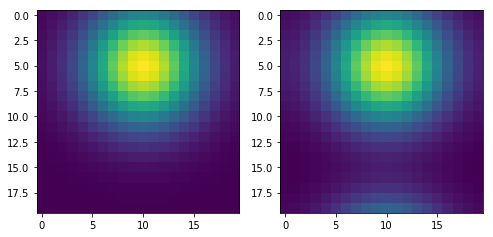

(17.4004398519+1.20851664782e-14j)


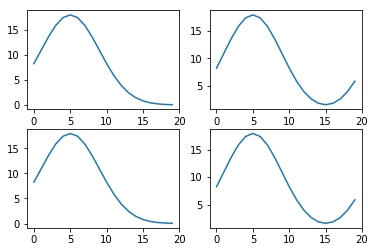

In [13]:
from scipy import ndimage

numberOfSamplings = U.shape[0]
numberOfBasis = size

l = SIGMA
init_alpha = I*l*np.sqrt(2*PI)
init_Cx = Cx
init_Cy = Cy
init_U = U.astype(int)
factor = (IMAGE_SIZE_X*IMAGE_SIZE_Y/20)

PHI_Re, PHI_Im = Vobs_function(init_U,l,init_alpha,init_Cx,init_Cy, IMAGE_SIZE_X = IMAGE_SIZE_X, IMAGE_SIZE_Y = IMAGE_SIZE_Y)

def matrix_points(U,V_real, V_imag, IMAGE_SIZE_X = 20, IMAGE_SIZE_Y = 20):
    U = U.astype(int)
    out_real = np.zeros([IMAGE_SIZE_X, IMAGE_SIZE_Y])
    out_imag = np.zeros([IMAGE_SIZE_X, IMAGE_SIZE_Y])
    for i in range(U.shape[0]):
        out_real[U[i,0],U[i,1]] = V_real[i]
        out_imag[U[i,0],U[i,1]] = V_imag[i]
        
    return out_real, out_imag


Im_pix_real, Im_pix_imag = matrix_points(U,V[:,0], V[:,1])
Im_pix_fft = Im_pix_real + 1j*Im_pix_imag
Im_pix = np.fft.ifft2(Im_pix_fft)
fig, ax = plt.subplots(1,2)
fig.set_figheight(10)
fig.set_figwidth(8)
ax[0].imshow( np.abs(Im_pix) )
print(np.max(Im_pix))

Im_ind_real, Im_ind_imag = matrix_points(U,PHI_Re.eval(), PHI_Im.eval())
#Im_ind_real = ndimage.rotate(Im_ind_real, 90*2)
#Im_ind_imag = ndimage.rotate(Im_ind_imag, 90*2)
# Im_ind = np.log(np.sqrt(Im_ind_real*Im_ind_real+Im_ind_imag*Im_ind_imag) +1e-12)
Im_ind_fft = Im_ind_real + 1j*Im_ind_imag
Im_ind = np.fft.ifft2(Im_ind_fft)
#Im_ind = np.fft.fftshift(Im_ind)
ax[1].imshow( np.abs(Im_ind) )
plt.show(fig)
print(np.max(Im_ind))

fig, ax = plt.subplots(2,2)
ax[0,0].plot(np.abs(Im_pix[:,10]))
ax[0,1].plot(np.abs(Im_ind[:,10]))
ax[1,0].plot(np.abs(Im_pix[:,10]))
ax[1,1].plot(np.abs(Im_ind[:,10]))
plt.show()

In [14]:
#from scipy import optimize

numberOfSamplings = U.shape[0]
numberOfBasis = size
rbf_model = pm.Model()

l = SIGMA
init_alpha = I*l*np.sqrt(2*PI)
init_Cx = Cx
init_Cy = Cy
init_sigma = 10*np.array([[1,1],[1,2]])

print('Initial Conditions:')
print('Number of Basis: %s; Number of Samplings: %s' % (numberOfBasis, numberOfSamplings))
print('Cx,Cy: %s,%s; ' % (init_Cx,init_Cy)),
print('alpha: %s; ' % (init_alpha)),
print('l: %s' % l)
with rbf_model:
    alpha_model = pm.Normal('alpha', mu=init_alpha, sd=200, shape = [1, numberOfBasis])
    Cx_model = pm.Gamma('Cx', alpha=0.5*(init_Cx)+1, beta=0.5, shape = [1, numberOfBasis])
    Cy_model = pm.Gamma('Cy', alpha=0.5*(init_Cy)+1, beta=0.5, shape = [1, numberOfBasis])
    l_model = pm.Gamma('l', alpha = 0.5*l+1, beta=0.5, shape = 1)
    
#     nu = pm.Uniform('nu', 0, 1000)
#     C_triu = pm.LKJCorr('C_triu', nu, 2, testval=init_corr)
#     C = pm.Deterministic('C', tt.fill_diagonal(C_triu[np.zeros((2, 2), dtype=np.int64)], 1.))

#     sigma_diag = pm.Deterministic('sigma_mat', tt.nlinalg.diag(sigma))
#     sigma_model = pm.Deterministic('cov', tt.nlinalg.matrix_dot(sigma_diag, C, sigma_diag))
    
    sd_dist = pm.Normal.dist(0,2)
    packed_chol = pm.LKJCholeskyCov('chol_cov', eta=2, n=2, sd_dist=sd_dist)
    chol = pm.expand_packed_triangular(2, packed_chol, lower=True)
    sigma_model = tt.dot(chol, chol.T)
    
#     sigma_model = pm.Lognormal('sigma', init_sigma, np.ones(2), shape=(2,2), testval=init_sigma)

    PHI_Re, PHI_Im = Vobs_function(U, l_model, alpha_model, Cx_model, Cy_model)
    V_model = tt.stack([PHI_Re, PHI_Im], axis = 1)
    
#     V_obs = pm.MvNormal('V_obs', mu=V_model, cov=sigma_model, observed=V)
    V_obs = pm.MvNormal('V_obs', mu=V_model, cov=sigma_model, observed=V)
    
#     db = pm.backends.Text('test_log_normal')
    n_samples = 1000
    
#     step = pm.Metropolis()
    step = pm.Slice()
    trace = pm.sample(n_samples, step)
#     estimation = pm.find_MAP()
#     print(estimation)

Initial Conditions:
Number of Basis: 1; Number of Samplings: 400
Cx,Cy: [10],[5]; 
alpha: [ 1804.77235773]; 
l: 4


/home/lerko/anaconda3/lib/python3.6/site-packages/pymc3/sampling.py:166: UserWarning: Instantiated step methods cannot be automatically initialized. init argument ignored.
  warnings.warn('Instantiated step methods cannot be automatically initialized. init argument ignored.')
100%|██████████| 1000/1000 [32:23<00:00,  1.84s/it] 


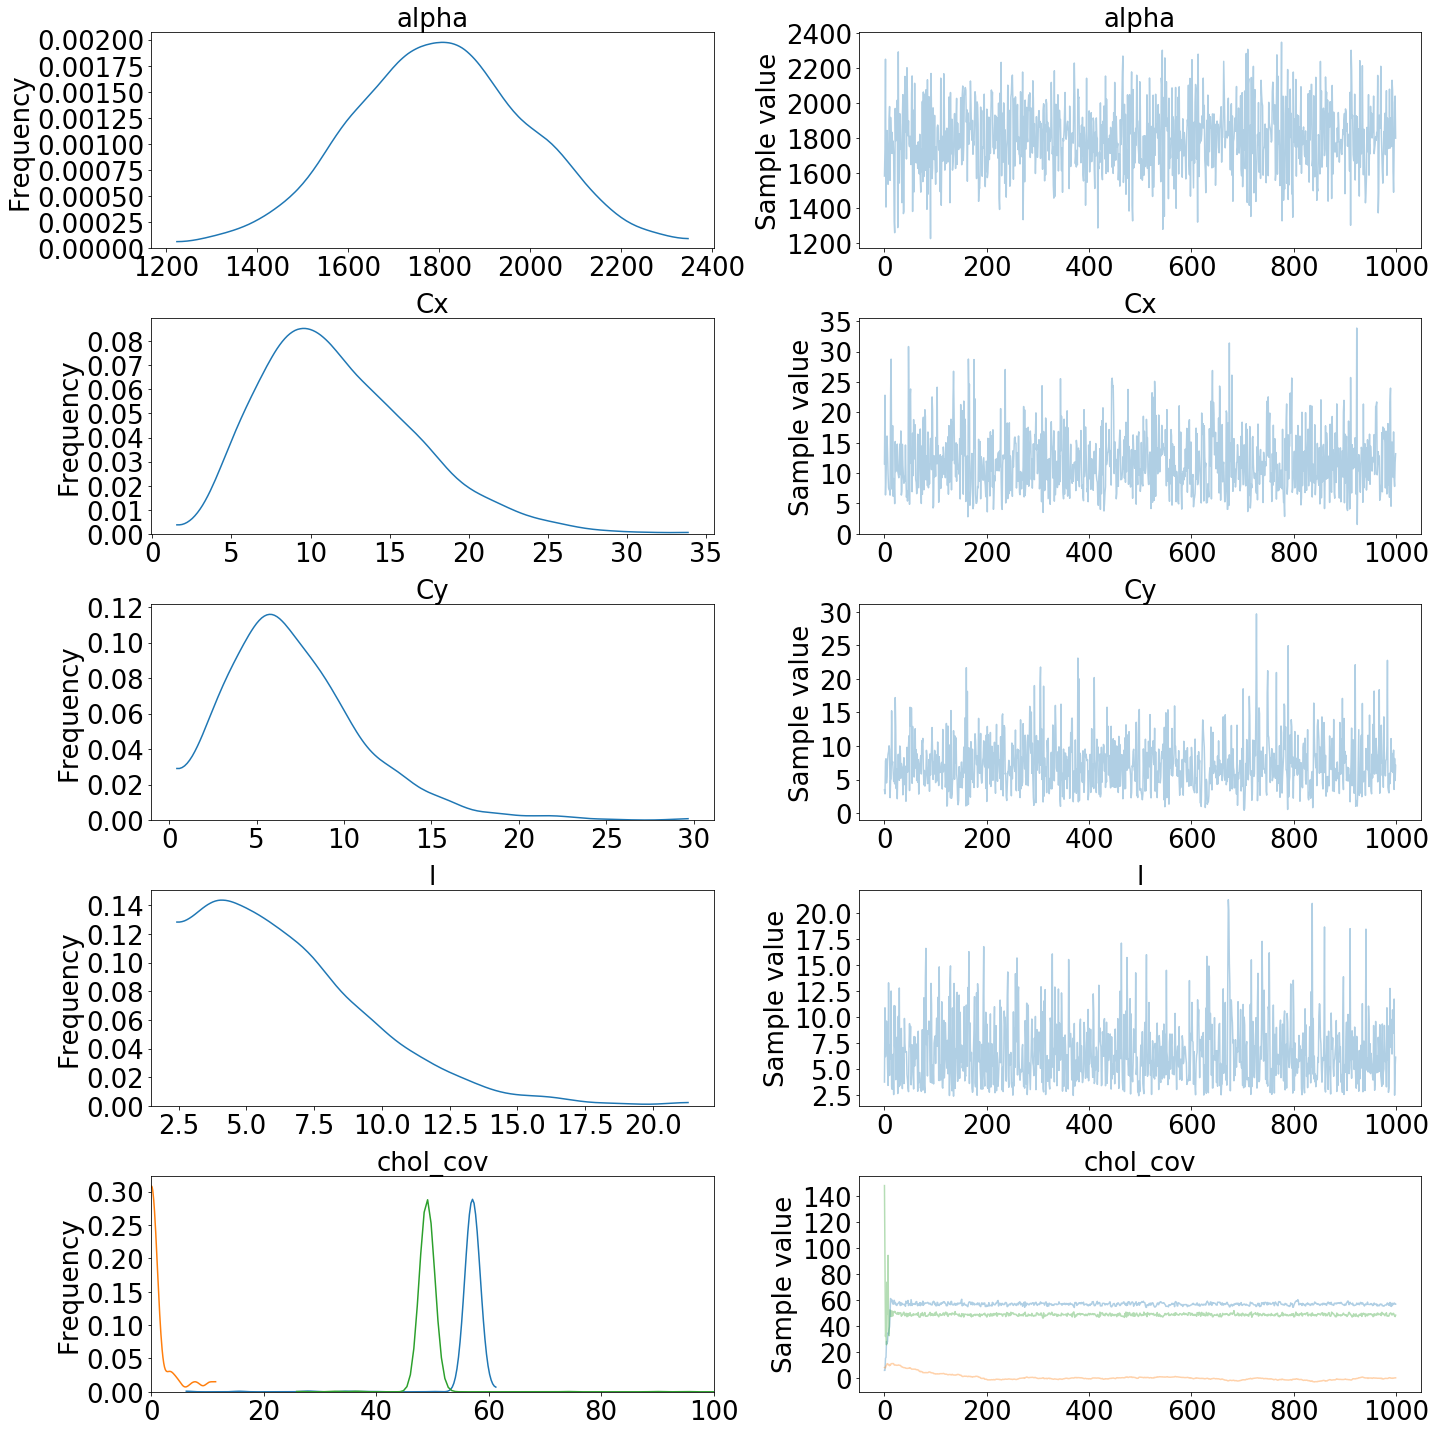

In [15]:
ax = pm.traceplot(trace, figsize=(20,20))

for i in range(5):
    for j in range(2):
        axe = ax[i,j]
        for item in ([axe.title, axe.xaxis.label, axe.yaxis.label] +
                     axe.get_xticklabels() + axe.get_yticklabels()):
            item.set_fontsize(26)

#ax[1,0].set_xlim([0., 50])
#ax[2,0].set_xlim([0., 50])
ax[4,0].set_xlim([0., 100])
plt.tight_layout()
plt.savefig('trace_gamma-centers.png', format='png')
plt.show()

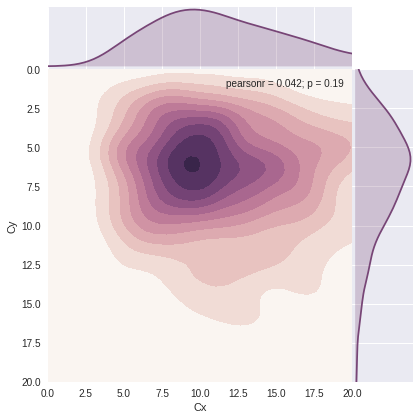

In [16]:
import seaborn as sns
import pandas as pd
from matplotlib import colors as mcolors

centers_join = np.concatenate([trace['Cx'][:,0], trace['Cy'][:,0]], axis=1)
centers_join_pd = pd.DataFrame(centers_join, columns=["Cx", "Cy"])

#print(centers_join_pd)
#sns.palplot(sns.cubehelix_palette(8)[4])
#sns.set(style="white", color_codes=True)
cmap = sns.cubehelix_palette(light=1, as_cmap=True)
g = sns.jointplot(x="Cx", y="Cy", data=centers_join_pd,
                  kind="kde", space=0, cmap=cmap, color=sns.cubehelix_palette(8)[5],
                  xlim=(0,20), ylim=(0,20))
g.ax_marg_y.invert_yaxis()
#g.ax_marg_x.pcolor(cmap=cmap)
sns.plt.show()